<a href="/assets/tutorial12_example.ipynb" class="link-button">Download</a>
<a href="https://colab.research.google.com/github/technion046195/technion046195/blob/master/content/tutorial12/example.ipynb" target="_blank">
<img src="../assets/colab-badge.svg" style="display:inline"/>
</a>

<center><h1>
תרגול 12 - דוגמא מעשית
</h1></center>

## Setup

In [ ]:
## Importing packages
import os # A build in package for interacting with the OS. For example to create a folder.
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package
import imageio  # A package to read and write image (is used here to save gif images)
import tabulate  # A package from pretty printing tables
from graphviz import Digraph  # A package for plothing graphs (of nodes and edges)
import tqdm.notebook as tqdm

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

## Setting some nice matplotlib defaults
plt.rcParams['figure.figsize'] = (4.5, 4.5)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Auxiliary function for prining equations, pandas tables and images in cells output
from IPython.core.display import display, HTML, Latex, Markdown

## Create output folder
if not os.path.isdir('./output'):
    os.mkdir('./output')

### Data Inspection

In [ ]:
data_file = 'https://technion046195.netlify.app/datasets/titanic_manifest.csv'

## Loading the data
dataset = pd.read_csv(data_file)

## Print the number of rows in the data set
number_of_rows = len(dataset)
display(Markdown(f'Number of rows in the dataset: $N={number_of_rows}$'))

## Show the first 10 rows
dataset

Number of rows in the dataset: $N=999$

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,numeric_sex
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1
2,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",0
3,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1
4,1,1,"Anderson, Mr. Harry",male,48,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,3,0,"Wittevrongel, Mr. Camille",male,36,0,0,345771,9.5000,NaN,S,NaN,NaN,NaN,0
995,3,0,"Yasbeck, Mr. Antoni",male,27,1,0,2659,14.4542,NaN,C,C,NaN,NaN,0
996,3,1,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15,1,0,2659,14.4542,NaN,C,NaN,NaN,NaN,1
997,3,0,"Zakarian, Mr. Ortin",male,27,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN,0


### The Data Fields and Types
In this workshop we will use the following fields:
- **pclass**: the ticket's class: 1st, 2nd or 3rd: 1, 2 or 3
- **sex**: the sex of the passenger as a string: male or female
- **age**: the passenger's age: an integer
- **sibsp**: the number of Siblings/Spouses aboard for each passenger: an integer
- **parch**: the number of Parents/Children aboard for each passenger: an integer
- **fare**: The price the passenger payed for the ticket: a positive real number
- **embarked**: The port in which the passenger embarked the ship: (C = Cherbourg; Q = Queenstown; S = Southampton)

- **survived**: The label for whether or not this passenger has survived: 0 or 1

(A full description for each of the other columns can be found [here](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt))

In [ ]:
discrete_columns = ['pclass', 'sex', 'sibsp', 'parch', 'embarked']
continuous_columns = ['age', 'fare']

## Train-Validation-Test split

In [ ]:
n_samples = len(dataset)

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(1)

## Generating a vector of indices
indices = np.arange(n_samples)

## Shuffle the indices
rand_gen.shuffle(indices)

## Split the indices into 60% train / 20% validation / 20% test
n_samples_train = int(n_samples * 0.6)
n_samples_val = int(n_samples * 0.2)
train_indices = indices[:n_samples_train]
val_indices = indices[n_samples_train:(n_samples_train + n_samples_val)]
test_indices = indices[(n_samples_train + n_samples_val):]

train_full_indices = np.concatenate((train_indices, val_indices))

train_full_set = dataset.iloc[train_full_indices]
train_set = dataset.iloc[train_indices]
val_set = dataset.iloc[val_indices]
test_set = dataset.iloc[test_indices]

## Some plots

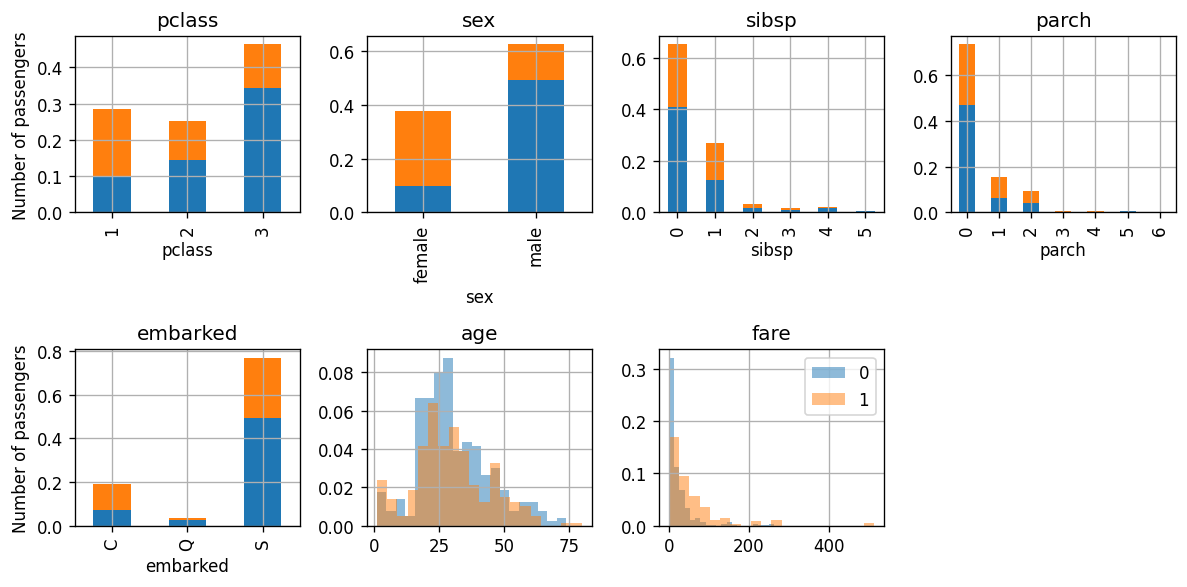

In [ ]:
def weighted_plot(dataset, weights):
    fig, ax_list = plt.subplots(2, 4, figsize=(10, 5))
    for i, feature in enumerate(discrete_columns):
        tmp = dataset[[feature, 'survived']].copy()
        tmp['weights'] = weights

        ax = ax_list.flat[i]
        
        tmp.groupby([feature, 'survived'])['weights'].sum().unstack('survived').plot.bar(ax=ax, stacked=True, legend=False)
        ax.set_title(feature)

    for i, feature in enumerate(continuous_columns):
        ax = ax_list.flat[i + len(discrete_columns)]
        ax.hist(dataset.query('survived == 0')[feature].values, bins=20, alpha=0.5, label='0', weights=weights[dataset['survived'] == 0])
        ax.hist(dataset.query('survived == 1')[feature].values, bins=20, alpha=0.5, label='1', weights=weights[dataset['survived'] == 1])
        ax.set_title(feature)

    for ax_list2 in ax_list:
        ax_list2[0].set_ylabel('Number of passengers')

    ax_list.flat[-1].remove()
    ax_list.flat[-2].legend()
    plt.tight_layout()
    return fig

weights = np.ones(len(train_full_set)) / len(train_full_set)
fig = weighted_plot(train_full_set, weights)
fig.savefig('./output/titanic_data_slices.png', dpi=240)

In [ ]:
class StumpCategory:
    def __init__(self, field, values):
        self.field = field
        self.map_func = {val: -1 for val in dataset[field].unique()}
        self.map_func.update({val: 1 for val in values})

    def predict(self, dataset):
        return dataset[self.field].map(self.map_func)
    
    def string(self):
        return f'{self.field}: {self.map_func}'

class StumpDiscreet:
    def __init__(self, field, threshold):
        self.field = field
        self.threshold = threshold

    def predict(self, dataset):
        return (dataset[self.field] > self.threshold).astype(int) * 2 - 1

    def string(self):
        return f'{self.field} > {self.threshold:.2f}'


In [ ]:
from itertools import chain, combinations

def adaboost_step(weights, dataset):
    y = dataset['survived'].values.astype(int) * 2 - 1
    
    best_stump = None
    best_score = np.inf
    
    for field in discrete_columns:
        all_values = np.unique(dataset[field].values)
        for values in chain.from_iterable(combinations(all_values, n) for n in range(len(all_values)+1)):
            stump = StumpCategory(field, values)
            score = ((stump.predict(dataset).values * y > 0).astype(int) * weights).sum()
            if score > 0.5:
                score = 1 - score
            if score < best_score:
                best_stump = stump
                best_score = score
    
    for field in continuous_columns:
        all_values = np.unique(dataset[field].values)
        thresholds = (all_values[1:] + all_values[:(-1)]) / 2
        for threshold in thresholds:
            stump = StumpDiscreet(field, threshold)
            score = ((stump.predict(dataset).values * y > 0).astype(int) * weights).sum()
            if score > 0.5:
                score = 1 - score
            if score < best_score:
                best_stump = stump
                best_score = score
    
    stump = best_stump
    score = ((stump.predict(dataset).values * y < 0).astype(int) * weights).sum()
    alpha = 0.5 * np.log((1 - score) / score)
    weights *= np.exp(-alpha * stump.predict(dataset).values * y)
    weights /= weights.sum()
    
    return stump, score, alpha, weights

In [ ]:
def calc_raw_y_hat(stumps, alphas, dataset):
    raw_y_hat = pd.Series(0, index=dataset.index)
    for stump, alpha in zip(stumps, alphas):
        raw_y_hat += alpha * stump.predict(dataset)
    return raw_y_hat

def calc_objective(stumps, alphas, dataset):
    y = dataset['survived'].values.astype(int) * 2 - 1
    raw_y_hat = calc_raw_y_hat(stumps, alphas, dataset)
    objective = np.exp(-y * raw_y_hat).mean()
    return objective

def predict(stumps, alphas, dataset):
    raw_y_hat = calc_raw_y_hat(stumps, alphas, dataset)
    y_hat = (raw_y_hat > 0).astype(int) * 2 - 1
    return y_hat

In [ ]:
weights = np.ones(len(train_set)) / len(train_set)
stumps = []
alphas = []

for step in tqdm.tqdm(range(1, 1001)):
    if (step <= 4):
        fig = weighted_plot(train_set, weights)
        fig.savefig(f'./output/titanic_adaboost_step_{step:02d}.png', dpi=240)
    
    stump, score, alpha, weights = adaboost_step(weights, train_set)
    stumps.append(stump)
    alphas.append(alpha)
    
#     objective = calc_objective(stumps, alphas, train_set)
#     train_score = ((predict(stumps, alphas, train_set) > 0) != train_set['survived']).mean()
#     val_score = ((predict(stumps, alphas, val_set) > 0) != val_set['survived']).mean()
    
#     print(f'Step {step}: {objective:.3f} - {train_score:.3f} \ {val_score:.3f}: {alpha:.4f} * {stump.string()}')    

In [ ]:
objective = calc_objective(stumps, alphas, train_set)
train_score = ((predict(stumps, alphas, train_set) > 0) != train_set['survived']).mean()
val_score = ((predict(stumps, alphas, val_set) > 0) != val_set['survived']).mean()

print(f'Step {step}: {objective:.3f} - {train_score:.3f} \ {val_score:.3f}')    

test_score = ((predict(stumps, alphas, test_set) > 0) != test_set['survived']).mean()
print(f'Test score: {test_score}')